# Emulators: First example

This example illustrates Bayesian inference on a time series, using [Adaptive Covariance MCMC](http://pints.readthedocs.io/en/latest/mcmc_samplers/adaptive_covariance_mcmc.html) with emulator neural networks .

It follows on from [Sampling: First example](../sampling/first-example.ipynb)

Like in the sampling example, I start by importing pints:

In [1]:
import pints

C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\plagl\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passi

Next, I create a model class using the "Logistic" toy model included in pints:

In [2]:
import pints.toy as toy

class RescaledModel(pints.ForwardModel):
    def __init__(self):
        self.base_model = toy.LogisticModel()
    
    def simulate(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulate([r, k], times)
    
    def simulateS1(self, parameters, times):
        # Run a simulation with the given parameters for the
        # given times and return the simulated values
        r, k = parameters
        r = r / 50
        k = k * 500
        return self.base_model.simulateS1([r, k], times)
    
    def n_parameters(self):
        # Return the dimension of the parameter vector
        return 2

# Rescale parameters
#found_parameters = list(found_parameters)
#found_parameters[0] = found_parameters[0] / 50
#found_parameters[1] = found_parameters[1] * 500

# Show score of true solution
#print('Score at true solution: ')
#print(score(true_parameters))

# Compare parameters with original
#print('Found solution:          True parameters:' )
#for k, x in enumerate(found_parameters):
    #print(pints.strfloat(x) + '    ' + pints.strfloat(true_parameters[k]))
    
model = toy.LogisticModel()

In order to generate some test data, I choose an arbitrary set of "true" parameters:

In [3]:
true_parameters = [0.015, 500]
start_parameters = [0.75, 1.0]

And a number of time points at which to sample the time series:

In [4]:
import numpy as np
times = np.linspace(0, 1000, 400)

Using these parameters and time points, I generate an example dataset:

In [5]:
org_values = model.simulate(true_parameters, times)
range_values = max(org_values) - min(org_values)

And make it more realistic by adding gaussian noise:

In [6]:
noise = 0.05 * range_values
print("The noise is:", noise)
values = org_values + np.random.normal(0, noise, org_values.shape)
values = org_values + np.random.normal(0, noise, org_values.shape)

The noise is: 24.898095903089327


Using matplotlib, I look at the noisy time series I just simulated:

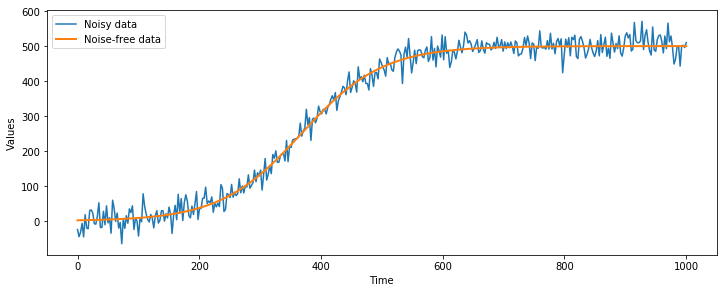

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4.5))
plt.xlabel('Time')
plt.ylabel('Values')
plt.plot(times, values, label='Noisy data')
plt.plot(times, org_values, lw=2, label='Noise-free data')
plt.legend()
plt.show()

Now, I have enough data (a model, a list of times, and a list of values) to formulate a PINTS problem:

In [8]:
model = RescaledModel()
problem = pints.SingleOutputProblem(model, times, values)

I now have some toy data, and a model that can be used for forward simulations. To make it into a probabilistic problem, a _noise model_ needs to be added. This can be done using the `GaussianLogLikelihood` function, which assumes independently distributed Gaussian noise over the data, and can calculate log-likelihoods:

In [9]:
#log_likelihood = pints.GaussianLogLikelihood(problem)
log_likelihood = pints.GaussianKnownSigmaLogLikelihood(problem, noise)

This `log_likelihood` represents the _conditional probability_ $p(y|\theta)$, given a set of parameters $\theta$ and a series of $y=$ `values`, it can calculate the probability of finding those values if the real parameters are $\theta$.

This can be used in a Bayesian inference scheme to find the quantity of interest:

$p(\theta|y) = \frac{p(\theta)p(y|\theta)}{p(y)} \propto p(\theta)p(y|\theta)$

To solve this, a _prior_ is defined, indicating an initial guess about what the parameters should be. 
Similarly as using a _log-likelihood_ (the natural logarithm of a likelihood), this is defined by using a _log-prior_. Hence, the above equation simplifies to:

$\log p(\theta|y) \propto \log p(\theta) + \log p(y|\theta)$

In this example, it is assumed that we don't know too much about the prior except lower and upper bounds for each variable: We assume the first model parameter is somewhere on the interval $[0.01, 0.02]$, the second model parameter on $[400, 600]$, and the standard deviation of the noise is somewhere on $[1, 100]$.

In [10]:
# Create bounds for our parameters and get prior
#bounds = pints.RectangularBoundaries([0.01, 400], [0.02, 600])
bounds = pints.RectangularBoundaries([0.5, 0.8], [1.0, 1.2])
log_prior = pints.UniformLogPrior(bounds)

With this prior, the numerator of Bayes' rule can be defined -- the unnormalised log posterior, $\log \left[ p(y|\theta) p(\theta) \right]$, which is the natural logarithm of the likelihood times the prior:

In [11]:
# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

Finally we create a list of guesses to use as initial positions. We'll run three MCMC chains so we create three initial positions:

In [12]:
xs = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05,
    np.array(start_parameters) * 1.15,
]

And this gives us everything we need to run an MCMC routine:

In [13]:
chains = pints.mcmc_sample(log_posterior, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.667     0          0:00.0
3     12     0.25      0.5       0          0:00.0
20    63     0.0476    0.0952    0.19       0:00.0
40    123    0.0244    0.0732    0.0976     0:00.0
60    183    0.0164    0.0492    0.0656     0:00.1
80    243    0.0123    0.037     0.0494     0:00.1
100   303    0.0099    0.0297    0.0396     0:00.1
120   363    0.00826   0.0248    0.0331     0:00.1
140   423    0.00709   0.0213    0.0284     0:00.1
160   483    0.00621   0.0248    0.0248     0:00.1
180   543    0.00552   0.0276    0.0221     0:00.1
Initial phase completed.
200   603    0.00498   0.0299    0.0249     0:00.1
220   663    0.0362    0.0543    0.0498     0:00.2
240   723    0.0871    0.0913    0.0913     0:00.2
260   783   

3280  9843   0.22      0.223     0.221274   0:02.4
3300  9903   0.219     0.224     0.221      0:02.5
3320  9963   0.218     0.22433   0.221      0:02.5
3340  10023  0.218     0.224     0.222      0:02.5
3360  10083  0.218     0.223     0.223      0:02.5
3380  10143  0.219     0.223     0.224      0:02.5
3400  10203  0.218     0.222     0.223      0:02.5
3420  10263  0.218     0.222     0.222      0:02.5
3440  10323  0.218     0.222     0.223      0:02.6
3460  10383  0.218     0.222     0.223      0:02.6
3480  10443  0.218     0.221     0.223      0:02.6
3500  10503  0.219     0.222     0.223      0:02.6
3520  10563  0.219     0.221812  0.222664   0:02.6
3540  10623  0.219     0.222     0.223      0:02.6
3560  10683  0.221     0.222     0.223      0:02.6
3580  10743  0.220888  0.223     0.223      0:02.7
3600  10803  0.221     0.222     0.222      0:02.7
3620  10863  0.221     0.22      0.222      0:02.7
3640  10923  0.222     0.219     0.222      0:02.7
3660  10983  0.223     0.219   

6580  19743  0.227625  0.226     0.224434   0:04.9
6600  19803  0.228     0.227     0.224      0:04.9
6620  19863  0.228     0.227     0.224      0:04.9
6640  19923  0.227     0.226     0.224      0:04.9
6660  19983  0.227     0.226     0.224741   0:04.9
6680  20043  0.227     0.226     0.225      0:04.9
6700  20103  0.226981  0.226     0.225      0:05.0
6720  20163  0.227     0.226     0.225      0:05.0
6740  20223  0.227     0.227     0.224      0:05.0
6760  20283  0.227     0.22615   0.224      0:05.0
6780  20343  0.227     0.226     0.225      0:05.0
6800  20403  0.227     0.226     0.225      0:05.0
6820  20463  0.227     0.227     0.225      0:05.0
6840  20523  0.227     0.227     0.225      0:05.1
6860  20583  0.227     0.227     0.225      0:05.1
6880  20643  0.227     0.227     0.225258   0:05.1
6900  20703  0.228     0.227     0.225      0:05.1
6920  20763  0.227     0.227     0.225401   0:05.1
6940  20823  0.227     0.227     0.225      0:05.1
6960  20883  0.228     0.227   

9940  29823  0.231     0.228649  0.228      0:07.3
9960  29883  0.231     0.229     0.228      0:07.3
9980  29943  0.231     0.228935  0.228      0:07.4
10000 30000  0.2308    0.2287    0.2281     0:07.4
Halting: Maximum number of iterations (10000) reached.


In [14]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_rescaled = np.copy(chains)
chain_rescaled = chains_rescaled[0]
chain_rescaled = chain_rescaled[2000:]

chains = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains])

## Using Pints' diagnostic plots to inspect the results

We can take a further look at the obtained results using Pints's [diagnostic plots](http://pints.readthedocs.io/en/latest/diagnostic_plots.html).

First, we use the [trace](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.trace) method to see if the three chains converged to the same solution.

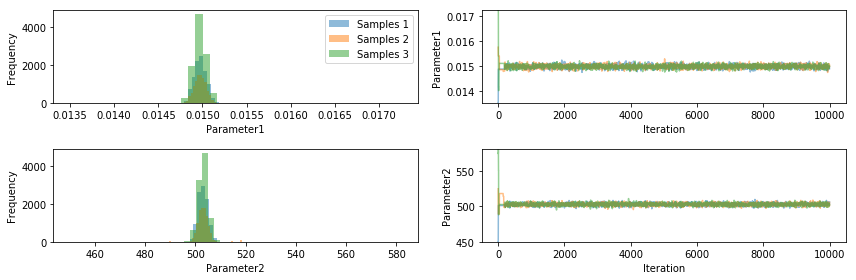

In [15]:
import pints.plot
pints.plot.trace(chains)
plt.show()

Based on this plot, it looks like the three chains become very similar after about 1000 iterations.
To be safe, we throw away the first 2000 samples and continue our analysis with the first chain.

In [16]:
chain = chains[0]
chain = chain[2000:]

We can also look for autocorrelation in the chains, using the [autocorrelation()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.autocorrelation) method. If everything went well, the samples in the chain should be relatively independent, so the autocorrelation should get quite low when the `lag` on the x-axis increases.

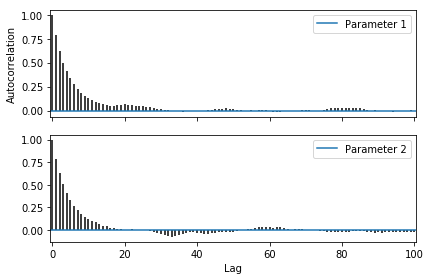

In [17]:
pints.plot.autocorrelation(chain)
plt.show()

Now we can inspect the inferred distribution by plotting histograms:

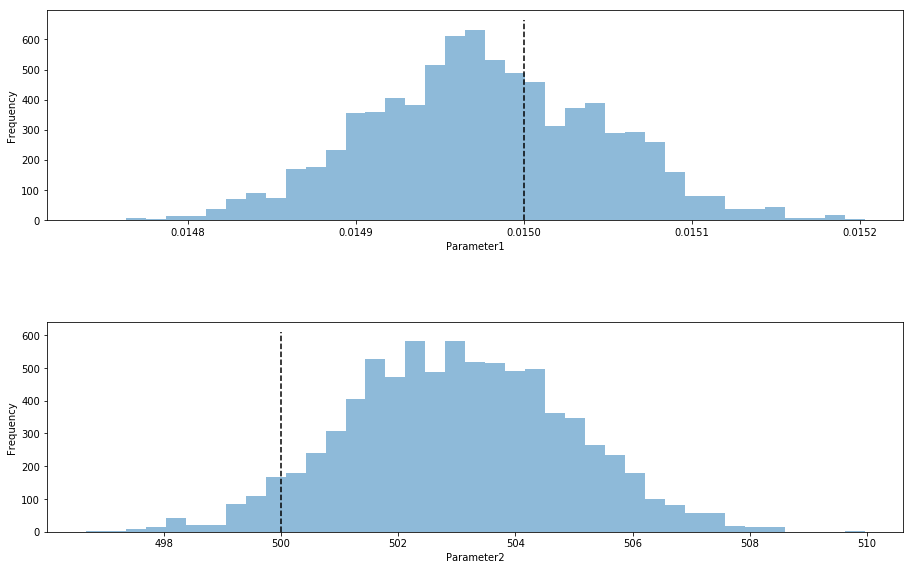

In [18]:
fig, axes = pints.plot.histogram([chain], ref_parameters=true_parameters)

# Show where the sample standard deviation of the generated noise is:
noise_sample_std = np.std(values - org_values)
#axes[-1].axvline(noise_sample_std, color='orange', label='Sample standard deviation of noise')
#axes[-1].legend()

fig.set_size_inches(14, 9)
plt.show()

Here we've analysed each parameter in isolation, but we can also look at correlations between parameters we found using the [pairwise()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.pairwise) plot.

To speed things up, we'll first apply some _thinning_ to the chain:

In [19]:
thinned_chain = chain[::10]

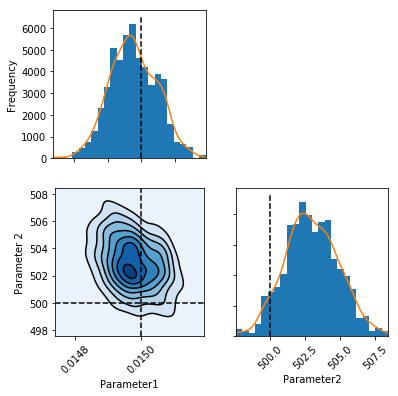

In [20]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

Finally, we can look at the bit that really matters: The model predictions made from models with the parameters we found (a _posterior predictive check_). Thes can be plotted using the [series()](http://pints.readthedocs.io/en/latest/diagnostic_plots.html#pints.plot.series) method.

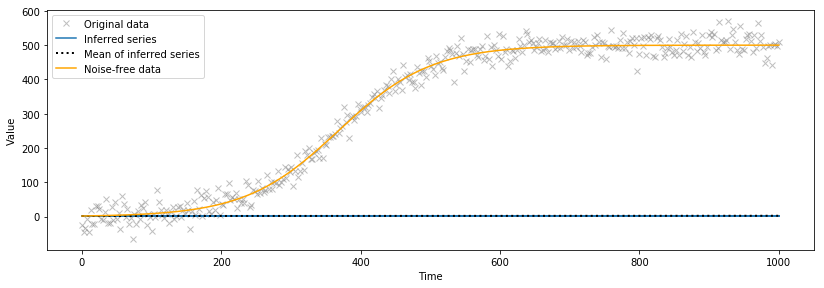

In [21]:
fig, axes = pints.plot.series(chain, problem)

# Customise the plot, and add the original, noise-free data
fig.set_size_inches(12,4.5)
plt.plot(times, org_values, c='orange', label='Noise-free data')
plt.legend()
plt.show()

-1842.303141918368
[0.74425977 1.01391065]
-47401.68518725355


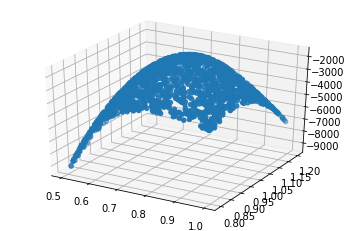

In [22]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 

input_parameters = log_prior.sample(2000)
x = [p[0] for p in input_parameters]
y = [p[1] for p in input_parameters]
input_parameters[:5]

likelihoods = np.apply_along_axis(log_likelihood, 1, input_parameters)
likelihoods[:5]

print(max(likelihoods))
idx = list(likelihoods).index(max(likelihoods))
print(input_parameters[idx])
print(log_likelihood([0.015, 500]))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, list(likelihoods))
plt.show()

In [23]:
print(input_parameters[:5])

[[0.95651942 1.01180231]
 [0.6897476  1.186403  ]
 [0.98542747 0.984319  ]
 [0.9506291  1.14427233]
 [0.60253209 0.91549336]]


In [24]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(input_parameters, likelihoods, test_size=0.3, random_state=0)
emu = pints.MultiLayerNN(problem, X_train, y_train, input_scaler=MinMaxScaler(), output_scaler=StandardScaler())
emu.set_parameters(layers=6, neurons=64, hidden_activation='relu', activation='linear', learning_rate=0.0001)
hist = emu.fit(epochs=500, batch_size=32, X_val=X_valid, y_val=y_valid, verbose=0)
emu.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                192       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 65        
Total params: 82,753
Trainable params: 82,753
Non-trainable params: 0
_________________________________________________________________


In [25]:
emu([0.015, 500])

array([[-5163122.]], dtype=float32)

In [26]:
log_likelihood([0.015, 500])

-47401.68518725355

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error', 'rescaled_mae', 'rescaled_mse', 'val_rescaled_mae', 'val_rescaled_mse'])


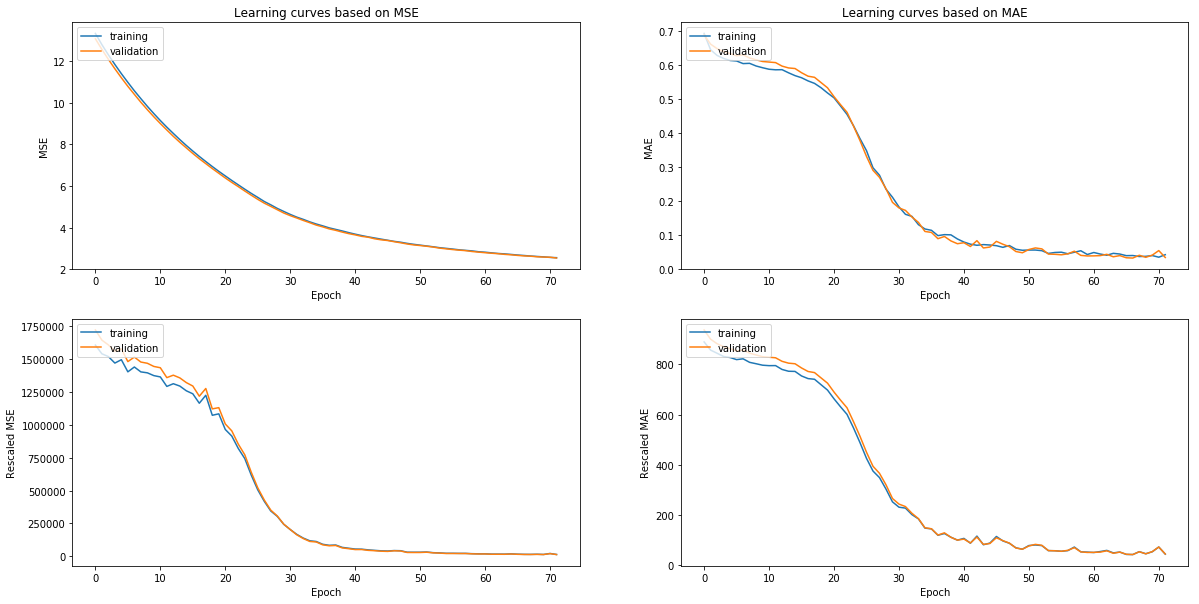

In [27]:
# summarize history for loss
print(hist.history.keys())
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20,10))                 
ax1.title.set_text('Learning curves based on MSE')
ax2.title.set_text('Learning curves based on MAE')

ax1.plot(hist.history['loss'])
ax1.plot(hist.history['val_loss'])
ax1.set_ylabel('MSE')
ax1.set_xlabel('Epoch')
ax1.legend(['training', 'validation'], loc='upper left')

ax2.plot(hist.history['mean_absolute_error'])
ax2.plot(hist.history['val_mean_absolute_error'])
ax2.set_ylabel('MAE')
ax2.set_xlabel('Epoch')
ax2.legend(['training', 'validation'], loc='upper left')

ax3.plot(hist.history['rescaled_mse'])
ax3.plot(hist.history['val_rescaled_mse'])
ax3.set_ylabel('Rescaled MSE')
ax3.set_xlabel('Epoch')
ax3.legend(['training', 'validation'], loc='upper left')

ax4.plot(hist.history['rescaled_mae'])
ax4.plot(hist.history['val_rescaled_mae'])
ax4.set_ylabel('Rescaled MAE')
ax4.set_xlabel('Epoch')
ax4.legend(['training', 'validation'], loc='upper left')

plt.show()

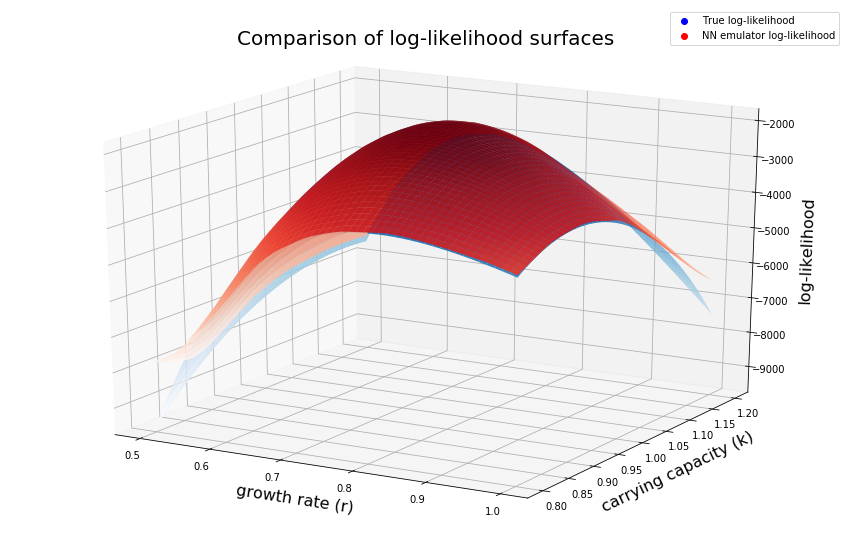

0.010918871039867661

In [28]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D 

test_splits = 50 # number of splits along each axis
r_grid, k_grid, test_data = pints.generate_grid(bounds.lower(), bounds.upper(), test_splits)
model_prediction = pints.predict_grid(log_likelihood, test_data)
emu_prediction = pints.predict_grid(emu, test_data)

figsize=(20,10)
angle=(20, 300)
alpha=0.9
fontsize=16
labelpad=10

title = "Comparison of log-likelihood surfaces"
x_label = "growth rate (r)"
y_label = "carrying capacity (k)"
z_label = "log-likelihood"


fig = plt.figure(figsize=(15,10))
ax = plt.axes(projection='3d')
ax.plot_surface(r_grid, k_grid, model_prediction, cmap='Blues', edgecolor='none', alpha=alpha)
ax.plot_surface(r_grid, k_grid, emu_prediction, cmap='Reds', edgecolor='none', alpha=alpha)
#ax.view_init(60, 35)
ax.view_init(*angle)
#ax.set_title('surface')

plt.title(title, fontsize=fontsize*1.25)
ax.set_xlabel(x_label, fontsize=fontsize, labelpad=labelpad)
ax.set_ylabel(y_label, fontsize=fontsize, labelpad=labelpad)
ax.set_zlabel(z_label, fontsize=fontsize, labelpad=labelpad)

fake2Dline1 = mpl.lines.Line2D([0],[0], linestyle="none", c='blue', marker = 'o')
fake2Dline2 = mpl.lines.Line2D([0],[0], linestyle="none", c='red', marker = 'o')
ax.legend([fake2Dline1, fake2Dline2], ["True log-likelihood", "NN emulator log-likelihood"])

plt.show()
mape = np.mean(np.abs((model_prediction - emu_prediction) / model_prediction))
mape

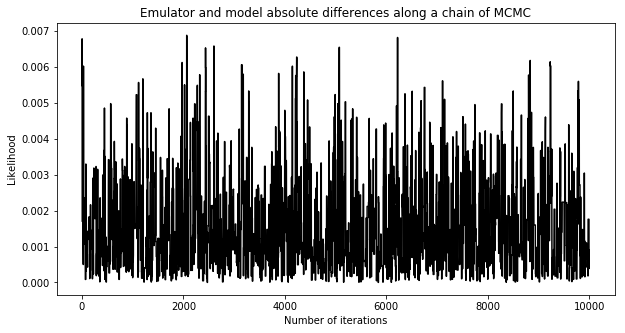

0.0009109372811849638

In [29]:
emu_prediction = np.apply_along_axis(emu, 1, chain_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [30]:
print(emu_prediction)

[-1834.1954 -1831.9438 -1831.9438 ... -1839.4694 -1843.4086 -1843.4086]


In [31]:
log_posterior_emu = pints.LogPosterior(emu, log_prior)

In [32]:
chains_emu = pints.mcmc_sample(log_posterior_emu, 3, xs)

Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.143     0.143     0.19       0:00.0
40    123    0.0732    0.0976    0.146      0:00.1
60    183    0.0492    0.082     0.131      0:00.1
80    243    0.037     0.0741    0.111      0:00.2
100   303    0.0396    0.0594    0.0891     0:00.2
120   363    0.0331    0.0496    0.0826     0:00.2
140   423    0.0284    0.0426    0.0709     0:00.3
160   483    0.0248    0.0373    0.0683     0:00.3
180   543    0.0221    0.0331    0.0663     0:00.3
Initial phase completed.
200   603    0.0199    0.0299    0.0597     0:00.4
220   663    0.0317    0.0588    0.0724     0:00.4
240   723    0.0788    0.0996    0.0954     0:00.5
260   783   

3120  9363   0.216     0.219     0.23       0:06.2
3140  9423   0.216     0.219     0.23       0:06.2
3160  9483   0.216     0.218     0.231      0:06.3
3180  9543   0.217     0.220371  0.231      0:06.3
3200  9603   0.217     0.22      0.232      0:06.3
3220  9663   0.218     0.220118  0.231      0:06.4
3240  9723   0.217834  0.221     0.23       0:06.4
3260  9783   0.218     0.222     0.229      0:06.5
3280  9843   0.219     0.222     0.228      0:06.5
3300  9903   0.22      0.222     0.228      0:06.5
3320  9963   0.22      0.223     0.228      0:06.6
3340  10023  0.22      0.224     0.228      0:06.6
3360  10083  0.219     0.224     0.228      0:06.7
3380  10143  0.219     0.224     0.227      0:06.7
3400  10203  0.218     0.223     0.226404   0:06.7
3420  10263  0.217     0.224     0.226      0:06.8
3440  10323  0.217     0.225     0.226      0:06.8
3460  10383  0.218     0.226     0.227102   0:06.8
3480  10443  0.217     0.226     0.228      0:06.9
3500  10503  0.217     0.227   

6420  19263  0.227     0.228     0.23       0:12.7
6440  19323  0.227     0.228     0.229778   0:12.7
6460  19383  0.227     0.228     0.229      0:12.8
6480  19443  0.227     0.228     0.23       0:12.8
6500  19503  0.227     0.228     0.23       0:12.9
6520  19563  0.227     0.228     0.23       0:12.9
6540  19623  0.227     0.227     0.23       0:12.9
6560  19683  0.227     0.228     0.23       0:13.0
6580  19743  0.227     0.228     0.229      0:13.0
6600  19803  0.227     0.228     0.23       0:13.1
6620  19863  0.227156  0.228     0.231      0:13.1
6640  19923  0.227     0.228     0.231      0:13.1
6660  19983  0.228     0.227     0.230596   0:13.2
6680  20043  0.228     0.227     0.23       0:13.2
6700  20103  0.226981  0.227     0.23       0:13.3
6720  20163  0.227     0.227     0.23       0:13.3
6740  20223  0.227266  0.227     0.23       0:13.3
6760  20283  0.227     0.227     0.231      0:13.4
6780  20343  0.227     0.227     0.23       0:13.4
6800  20403  0.228     0.227   

9680  29043  0.228902  0.23      0.233      0:19.2
9700  29103  0.229     0.229667  0.233      0:19.2
9720  29163  0.228     0.23      0.233      0:19.3
9740  29223  0.228     0.23      0.233      0:19.3
9760  29283  0.228     0.229     0.233      0:19.4
9780  29343  0.228     0.229     0.233      0:19.4
9800  29403  0.228242  0.229     0.233      0:19.4
9820  29463  0.22849   0.229     0.233      0:19.5
9840  29523  0.229     0.229     0.233      0:19.5
9860  29583  0.229     0.229     0.232735   0:19.6
9880  29643  0.229     0.229     0.23277    0:19.6
9900  29703  0.228     0.229     0.233      0:19.6
9920  29763  0.229     0.229     0.232537   0:19.7
9940  29823  0.228     0.229152  0.233      0:19.7
9960  29883  0.228     0.23      0.233      0:19.7
9980  29943  0.229     0.23      0.232      0:19.8
10000 30000  0.2289    0.2294    0.2324     0:19.8
Halting: Maximum number of iterations (10000) reached.


In [33]:
# Revert scaling
scaling_factors = [1/50, 500]
chains_emu_rescaled = np.copy(chains_emu)
chain_emu_rescaled = chains_emu_rescaled[0]
chain_emu_rescaled = chain_emu_rescaled[2000:]

chains_emu = np.array([[[s*f for s,f in zip(samples, scaling_factors)] for samples in chain] for chain in chains_emu])

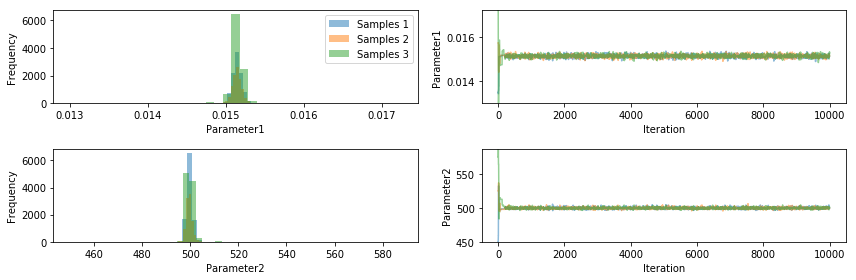

In [34]:
pints.plot.trace(chains_emu)
plt.show()

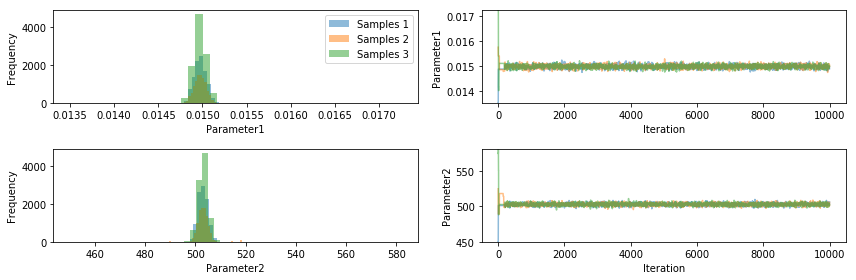

In [35]:
pints.plot.trace(chains)
plt.show()

In [36]:
chain_emu = chains_emu[0]
chain_emu = chain_emu[2000:]
chain = chains[0]
chain = chain[2000:]

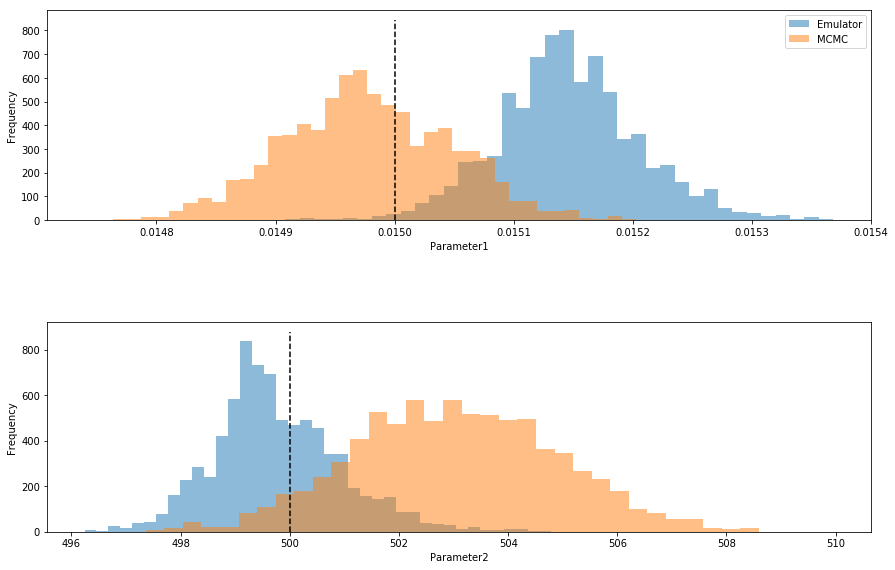

In [37]:
fig, axes = pints.plot.histogram([chain_emu, chain], ref_parameters=true_parameters, sample_names=["Emulator", "MCMC"])
fig.set_size_inches(14, 9)
plt.show()

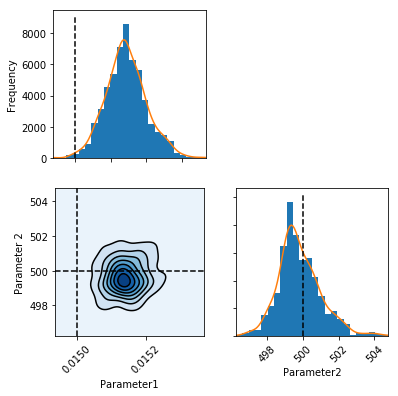

In [38]:
thinned_chain_emu = chain_emu[::10]
pints.plot.pairwise(thinned_chain_emu, kde=True, ref_parameters=true_parameters)
plt.show()

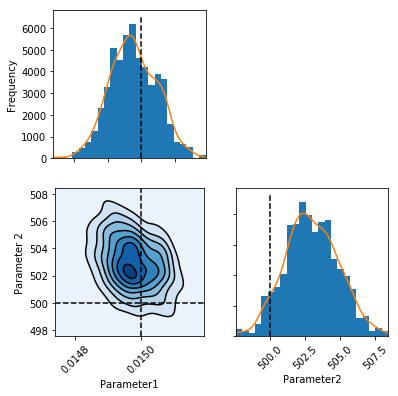

In [39]:
pints.plot.pairwise(thinned_chain, kde=True, ref_parameters=true_parameters)
plt.show()

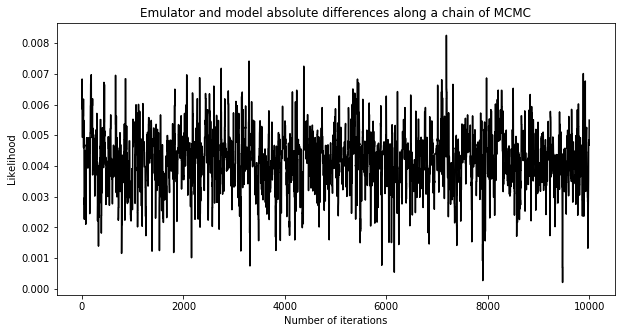

0.005492526566868059

In [40]:
emu_prediction = np.apply_along_axis(emu, 1, chain_emu_rescaled).flatten()
model_prediction = np.apply_along_axis(log_likelihood, 1, chain_rescaled).flatten()
diffs = (np.abs((model_prediction - emu_prediction) / model_prediction))

iters = np.linspace(0, 10000, len(chain_emu_rescaled))
plt.figure(figsize=(10, 5))
plt.title("Emulator and model absolute differences along a chain of MCMC")
plt.xlabel("Number of iterations")
plt.ylabel("Likelihood")
plt.plot(iters, diffs, color = "Black")
plt.show()

diffs[-1]

In [41]:
chain_emu

array([[1.52100212e-02, 5.00841176e+02],
       [1.51231790e-02, 4.99624469e+02],
       [1.51231790e-02, 4.99624469e+02],
       ...,
       [1.51373441e-02, 4.99644417e+02],
       [1.51373441e-02, 4.99644417e+02],
       [1.51373441e-02, 4.99644417e+02]])

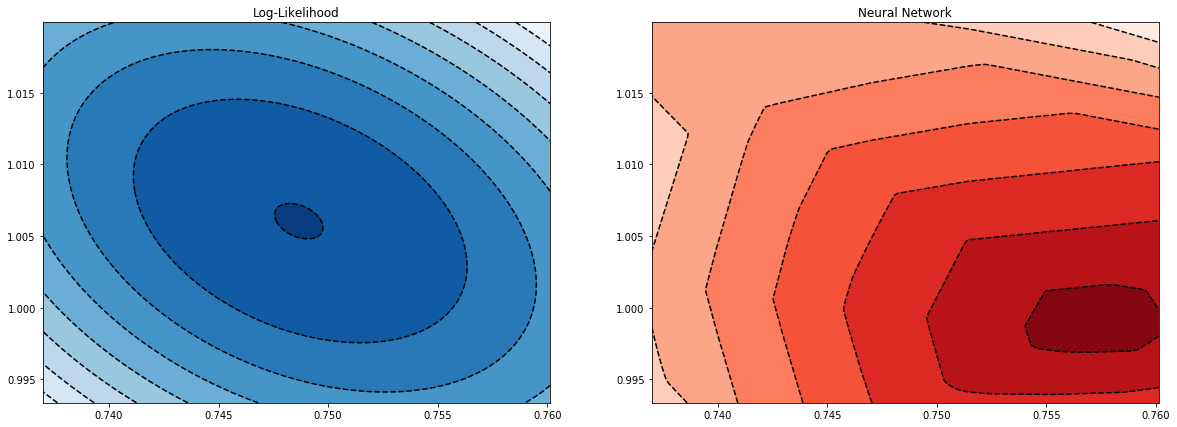

In [42]:
# Create grid of parameters
x = [p[0] for p in chain_rescaled]
y = [p[1] for p in chain_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood')
ax2.title.set_text('Neural Network')
ax1.contourf(xx, yy, ll, cmap='Blues', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='k')
ax2.contourf(xx, yy, ll_emu, cmap='Reds', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='k')
plt.show()

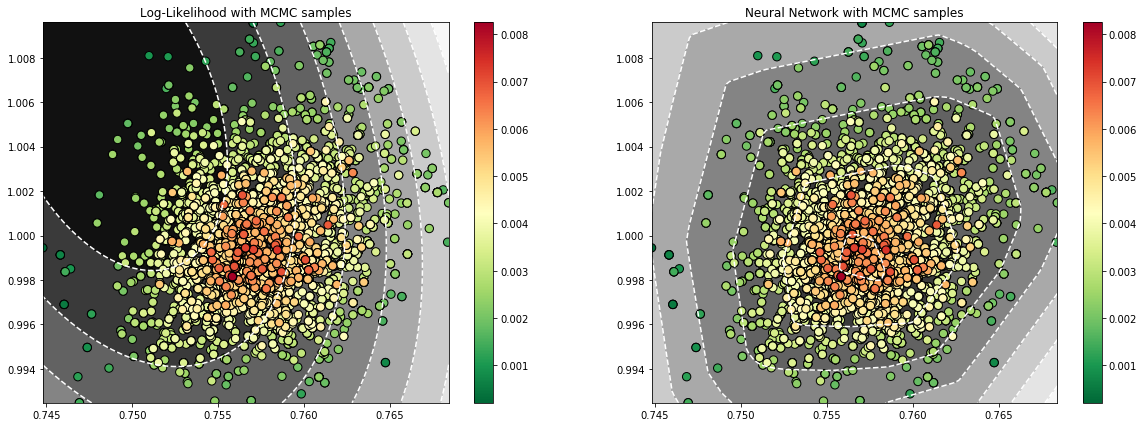

In [43]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.title.set_text('Log-Likelihood with MCMC samples')
ax2.title.set_text('Neural Network with MCMC samples')                                                                  

# Create grid of parameters
x = [p[0] for p in chain_emu_rescaled]
y = [p[1] for p in chain_emu_rescaled]
xmin, xmax = np.min(x), np.max(x)
ymin, ymax = np.min(y), np.max(y)
xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
params = [list(n) for n in zip(xx, yy)]
ll = np.apply_along_axis(log_likelihood, 1, params)
ll_emu = np.apply_along_axis(emu, 1, params)
ll_emu = [list(e[0][0]) for e in ll_emu]

# Sort according to differences in log-likelihood
idx = diffs.argsort()
x_sorted = np.array(x)[idx]
y_sorted = np.array(y)[idx]
diffs_sorted = diffs[idx]

# Add contour lines of log-likelihood
ax1.contourf(xx, yy, ll, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax1.contour(xx, yy, ll, colors='w')

# Plot chain_emu    
ax1.set_xlim([xmin, xmax])                                                                           
ax1.set_ylim([ymin, ymax])
im1 = ax1.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

# Add contour lines of emulated likelihood
ax2.contourf(xx, yy, ll_emu, cmap='Greys', extent=[xmin, xmax, ymin, ymax])
ax2.contour(xx, yy, ll_emu, colors='w')

# Plot chain_emu    
ax2.set_xlim([xmin, xmax])                                                                           
ax2.set_ylim([ymin, ymax])
im2 = ax2.scatter(x_sorted, y_sorted, c=diffs_sorted, s=70, edgecolor='k', cmap="RdYlGn_r")

fig.colorbar(im1, ax=ax1)
fig.colorbar(im2, ax=ax2)
plt.show()

Running...
Using Emulated Metropolis MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0          0:00.0
2     9      0.333     0.333     0.333      0:00.0
3     12     0.5       0.5       0.25       0:00.0
20    63     0.381     0.524     0.524      0:00.1
40    123    0.512     0.488     0.463      0:00.1
60    183    0.492     0.459     0.442623   0:00.2
80    243    0.519     0.432     0.444      0:00.2
100   303    0.495     0.376     0.475      0:00.3
120   363    0.479     0.338843  0.471      0:00.3
140   423    0.454     0.312     0.44       0:00.4
160   483    0.404     0.286     0.422      0:00.4
180   543    0.376     0.265     0.431      0:00.5
200   603    0.348     0.259     0.408      0:00.5
220   663    0.321267  0.249     0.38       0:00.6
240   723    0.311     0.232     0.369      0:00.6
260   783    0.295     0.23      0.372    

3180  9543   0.198     0.189563  0.199      0:07.7
3200  9603   0.198     0.189     0.199      0:07.7
3220  9663   0.197     0.189     0.2        0:07.8
3240  9723   0.197     0.19      0.199      0:07.8
3260  9783   0.198     0.190739  0.199      0:07.9
3280  9843   0.198     0.191     0.199      0:07.9
3300  9903   0.198     0.192     0.2        0:08.0
3320  9963   0.197832  0.192     0.199      0:08.0
3340  10023  0.197     0.193056  0.199      0:08.0
3360  10083  0.197     0.194     0.199      0:08.1
3380  10143  0.197     0.194     0.2        0:08.1
3400  10203  0.197883  0.193     0.199      0:08.2
3420  10263  0.198     0.193     0.198      0:08.2
3440  10323  0.199     0.193     0.198      0:08.3
3460  10383  0.199     0.193     0.198      0:08.3
3480  10443  0.199     0.194     0.198      0:08.4
3500  10503  0.198     0.193     0.199      0:08.4
3520  10563  0.2       0.193979  0.198      0:08.5
3540  10623  0.2       0.194     0.197      0:08.5
3560  10683  0.2       0.195   

6420  19263  0.197     0.199     0.196      0:15.3
6440  19323  0.196     0.198     0.196      0:15.3
6460  19383  0.196     0.199     0.196      0:15.4
6480  19443  0.196     0.198     0.196      0:15.4
6500  19503  0.196     0.198     0.195816   0:15.5
6520  19563  0.195     0.198     0.196      0:15.5
6540  19623  0.195383  0.198     0.196      0:15.6
6560  19683  0.196     0.198     0.195      0:15.6
6580  19743  0.196     0.198     0.195      0:15.7
6600  19803  0.196     0.197     0.194      0:15.7
6620  19863  0.196     0.197     0.194      0:15.8
6640  19923  0.196     0.197     0.194      0:15.8
6660  19983  0.196     0.197     0.194      0:15.8
6680  20043  0.197     0.197     0.193      0:15.9
6700  20103  0.196     0.197284  0.193      0:15.9
6720  20163  0.195953  0.197     0.193      0:16.0
6740  20223  0.197     0.197     0.193      0:16.0
6760  20283  0.197     0.197     0.193      0:16.1
6780  20343  0.197     0.197611  0.193      0:16.1
6800  20403  0.197471  0.197618

9720  29163  0.197     0.193     0.197      0:23.2
9740  29223  0.197105  0.194     0.196      0:23.2
9760  29283  0.198     0.193     0.197      0:23.3
9780  29343  0.197     0.193     0.197      0:23.3
9800  29403  0.197     0.193     0.197      0:23.4
9820  29463  0.197     0.193     0.197      0:23.4
9840  29523  0.197     0.193     0.196728   0:23.5
9860  29583  0.197     0.192374  0.197      0:23.5
9880  29643  0.197     0.192     0.19664    0:23.6
9900  29703  0.197     0.192     0.197      0:23.6
9920  29763  0.197     0.193     0.197      0:23.7
9940  29823  0.197     0.193     0.197      0:23.7
9960  29883  0.197     0.193     0.197      0:23.8
9980  29943  0.197     0.192     0.197      0:23.8
10000 30003  0.197     0.192     0.197      0:23.9
10020 30063  0.197     0.192     0.197      0:23.9
10040 30123  0.196594  0.191714  0.196594   0:23.9
10060 30183  0.197     0.192     0.197      0:24.0
10080 30243  0.196     0.192     0.197      0:24.0
10100 30303  0.196     0.192   

12960 38883  0.193     0.19      0.195      0:30.3
12980 38943  0.193     0.19      0.195      0:30.4
13000 39003  0.193     0.19      0.195      0:30.4
13020 39063  0.193     0.19      0.195      0:30.4
13040 39123  0.193     0.19      0.195      0:30.5
13060 39183  0.193     0.19      0.195      0:30.5
13080 39243  0.193     0.19      0.195      0:30.6
13100 39303  0.193     0.19      0.194718   0:30.6
13120 39363  0.193     0.190458  0.194      0:30.7
13140 39423  0.193     0.191     0.194      0:30.7
13160 39483  0.193     0.190639  0.194      0:30.8
13180 39543  0.193     0.191     0.194      0:30.8
13200 39603  0.193     0.19      0.193849   0:30.9
13220 39663  0.193     0.19      0.193707   0:30.9
13240 39723  0.193     0.19      0.194      0:31.0
13260 39783  0.193     0.19      0.193      0:31.0
13280 39843  0.193     0.18982   0.193133   0:31.1
13300 39903  0.193     0.189685  0.193      0:31.1
13320 39963  0.193     0.19      0.193      0:31.2
13340 40023  0.193     0.19    

16180 48543  0.192     0.189     0.192      0:37.9
16200 48603  0.19184   0.189     0.192      0:37.9
16220 48663  0.192     0.19      0.193      0:38.0
16240 48723  0.192     0.19      0.193      0:38.0
16260 48783  0.192     0.19      0.193      0:38.1
16280 48843  0.192     0.189     0.193      0:38.1
16300 48903  0.192     0.189     0.193      0:38.2
16320 48963  0.192     0.19      0.193      0:38.2
16340 49023  0.192     0.189     0.193      0:38.2
16360 49083  0.192     0.189     0.193      0:38.3
16380 49143  0.192357  0.19      0.193      0:38.3
16400 49203  0.192     0.19      0.192      0:38.4
16420 49263  0.192     0.189757  0.192      0:38.4
16440 49323  0.19202   0.19      0.192      0:38.5
16460 49383  0.192     0.19      0.192      0:38.5
16480 49443  0.192     0.189855  0.192      0:38.6
16500 49503  0.192     0.19      0.192      0:38.6
16520 49563  0.192     0.189819  0.192      0:38.7
16540 49623  0.192     0.19      0.192      0:38.7
16560 49683  0.192     0.19    

19460 58383  0.191     0.189     0.193      0:45.4
19480 58443  0.191     0.189     0.193      0:45.4
19500 58503  0.191     0.189     0.193      0:45.5
19520 58563  0.191     0.189     0.193      0:45.5
19540 58623  0.191     0.189     0.193      0:45.5
19560 58683  0.191     0.189     0.193      0:45.6
19580 58743  0.191     0.189214  0.193      0:45.6
19600 58803  0.191     0.189123  0.193      0:45.7
19620 58863  0.191     0.189     0.193      0:45.7
19640 58923  0.191     0.189     0.193      0:45.8
19660 58983  0.191     0.189     0.193      0:45.8
19680 59043  0.191     0.189     0.193      0:45.9
19700 59103  0.192     0.189     0.193      0:45.9
19720 59163  0.192     0.189     0.193      0:45.9
19740 59223  0.192     0.189     0.193      0:46.0
19760 59283  0.192     0.189     0.193      0:46.0
19780 59343  0.192     0.189     0.193      0:46.1
19800 59403  0.192     0.189     0.193      0:46.1
19820 59463  0.191615  0.189     0.193      0:46.2
19840 59523  0.191573  0.188801

22720 68163  0.19      0.188     0.191      0:53.1
22740 68223  0.19      0.188     0.191      0:53.1
22760 68283  0.190018  0.188     0.191      0:53.2
22780 68343  0.19      0.188     0.191      0:53.2
22800 68403  0.19      0.188     0.191      0:53.3
22820 68463  0.19      0.188     0.191      0:53.3
22840 68523  0.19      0.188     0.191      0:53.4
22860 68583  0.19      0.188     0.191      0:53.4
22880 68643  0.189983  0.188     0.191      0:53.5
22900 68703  0.19      0.188     0.190996   0:53.5
22920 68763  0.19      0.187819  0.191      0:53.6
22940 68823  0.19      0.188     0.191      0:53.6
22960 68883  0.19      0.188     0.191      0:53.7
22980 68943  0.19      0.188     0.191      0:53.7
23000 69003  0.19      0.188     0.191      0:53.8
23020 69063  0.19      0.188     0.191043   0:53.8
23040 69123  0.19      0.188     0.191      0:53.8
23060 69183  0.189801  0.188     0.190885   0:53.9
23080 69243  0.19      0.188     0.191      0:53.9
23100 69303  0.189732  0.188217

25940 77823  0.189     0.186     0.191      1:00.1
25960 77883  0.189     0.186395  0.191      1:00.2
25980 77943  0.189     0.186     0.191      1:00.2
26000 78003  0.189     0.186339  0.191      1:00.3
26020 78063  0.189     0.186     0.19       1:00.3
26040 78123  0.189     0.186     0.191      1:00.3
26060 78183  0.189     0.186     0.191      1:00.4
26080 78243  0.189     0.186     0.19       1:00.4
26100 78303  0.189     0.186     0.19       1:00.5
26120 78363  0.189     0.186     0.19       1:00.5
26140 78423  0.189396  0.186     0.19       1:00.6
26160 78483  0.189     0.186     0.19       1:00.6
26180 78543  0.189     0.186     0.19       1:00.6
26200 78603  0.189     0.186     0.19       1:00.7
26220 78663  0.189     0.186     0.19       1:00.7
26240 78723  0.189     0.186     0.19       1:00.8
26260 78783  0.189     0.186     0.19       1:00.8
26280 78843  0.189     0.187     0.19       1:00.8
26300 78903  0.189     0.187     0.190335   1:00.9
26320 78963  0.189     0.186   

29160 87483  0.189     0.186     0.19       1:06.7
29180 87543  0.189     0.186     0.19       1:06.8
29200 87603  0.189     0.186     0.19       1:06.8
29220 87663  0.189     0.186     0.19       1:06.8
29240 87723  0.189     0.186     0.190315   1:06.9
29260 87783  0.189433  0.186     0.19       1:06.9
29280 87843  0.189     0.186     0.19       1:07.0
29300 87903  0.19      0.186     0.19013    1:07.0
29320 87963  0.189     0.186     0.19       1:07.1
29340 88023  0.18953   0.186     0.19       1:07.1
29360 88083  0.19      0.186     0.190048   1:07.1
29380 88143  0.19      0.186     0.19       1:07.2
29400 88203  0.19      0.186     0.19       1:07.2
29420 88263  0.19      0.186     0.19       1:07.3
29440 88323  0.19      0.186     0.190143   1:07.3
29460 88383  0.19      0.186     0.19       1:07.4
29480 88443  0.19      0.186     0.19       1:07.4
29500 88503  0.19      0.186     0.19       1:07.4
29520 88563  0.19      0.186     0.19       1:07.5
29540 88623  0.19      0.186   

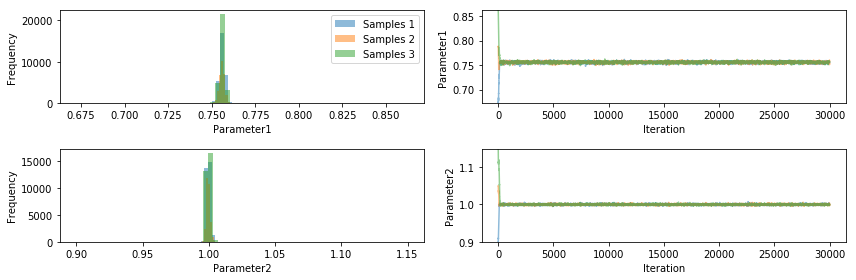

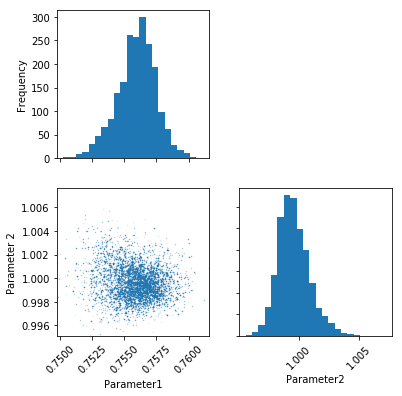

In [44]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-3
#sigma0 = [0.1*0.75, 0.1] #np.abs(true_parameters) * 5e-3
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior_emu, 3, x0s, sigma0=sigma0, method=pints.EmulatedMetropolisMCMC, f=log_posterior)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
emulated_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(emulated_chains)

# Discard warm up
emulated_chains_thinned = emulated_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(emulated_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(emulated_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Metropolis random walk MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0.5       0          0:00.0
2     9      0         0.333     0          0:00.0
3     12     0.25      0.5       0.25       0:00.0
20    63     0.571     0.619     0.429      0:00.0
40    123    0.561     0.585     0.341      0:00.0
60    183    0.541     0.59      0.377      0:00.0
80    243    0.543     0.568     0.42       0:00.1
100   303    0.515     0.574     0.465      0:00.1
120   363    0.496     0.603     0.463      0:00.1
140   423    0.518     0.589     0.468      0:00.1
160   483    0.522     0.584     0.497      0:00.1
180   543    0.525     0.575     0.503      0:00.1
200   603    0.512     0.572     0.527      0:00.1
220   663    0.529     0.575     0.534      0:00.2
240   723    0.535     0.564     0.539      0:00.2
260   783    0.54      0.563     0.54  

3280  9843   0.563     0.548     0.564      0:02.2
3300  9903   0.563     0.548     0.564      0:02.2
3320  9963   0.563     0.548     0.564      0:02.2
3340  10023  0.563     0.548     0.565      0:02.3
3360  10083  0.564     0.549     0.564      0:02.3
3380  10143  0.563     0.54895   0.563      0:02.3
3400  10203  0.564     0.548     0.563      0:02.3
3420  10263  0.565     0.548     0.562      0:02.3
3440  10323  0.564     0.548     0.563      0:02.3
3460  10383  0.565     0.547     0.562      0:02.3
3480  10443  0.565     0.546     0.562      0:02.4
3500  10503  0.566124  0.546     0.562982   0:02.4
3520  10563  0.567     0.546     0.564      0:02.4
3540  10623  0.566     0.546     0.565      0:02.4
3560  10683  0.565     0.547     0.564      0:02.4
3580  10743  0.565     0.548     0.565      0:02.4
3600  10803  0.565     0.548     0.565      0:02.4
3620  10863  0.563     0.548     0.566      0:02.5
3640  10923  0.563     0.547     0.565      0:02.5
3660  10983  0.564     0.547   

6560  19683  0.566     0.550221  0.565615   0:04.4
6580  19743  0.566     0.551     0.565      0:04.4
6600  19803  0.566     0.551     0.565      0:04.5
6620  19863  0.566     0.551     0.565      0:04.5
6640  19923  0.566     0.551     0.565      0:04.5
6660  19983  0.566     0.551     0.565      0:04.5
6680  20043  0.566532  0.551     0.565      0:04.5
6700  20103  0.566     0.552     0.566      0:04.5
6720  20163  0.567     0.552     0.565      0:04.5
6740  20223  0.567     0.552     0.566      0:04.6
6760  20283  0.567     0.552     0.565301   0:04.6
6780  20343  0.567173  0.552     0.566      0:04.6
6800  20403  0.567     0.553     0.566      0:04.6
6820  20463  0.566     0.553     0.565      0:04.6
6840  20523  0.567     0.553     0.565      0:04.6
6860  20583  0.567     0.553     0.563      0:04.6
6880  20643  0.567     0.553     0.563      0:04.6
6900  20703  0.567     0.554     0.564      0:04.7
6920  20763  0.567     0.554     0.565      0:04.7
6940  20823  0.567     0.554   

9820  29463  0.564     0.551064  0.569      0:06.6
9840  29523  0.564     0.551     0.57       0:06.7
9860  29583  0.564     0.551     0.569      0:06.7
9880  29643  0.564     0.551     0.569      0:06.7
9900  29703  0.564     0.551     0.57       0:06.7
9920  29763  0.564     0.551     0.569499   0:06.7
9940  29823  0.563726  0.551     0.569      0:06.7
9960  29883  0.563     0.551     0.57       0:06.7
9980  29943  0.563     0.551047  0.57       0:06.7
10000 30003  0.563     0.551     0.570043   0:06.8
10020 30063  0.563     0.551     0.57       0:06.8
10040 30123  0.562     0.551     0.571      0:06.8
10060 30183  0.562     0.551     0.571      0:06.8
10080 30243  0.562345  0.551     0.571      0:06.8
10100 30303  0.563     0.551     0.571      0:06.8
10120 30363  0.562     0.551     0.571      0:06.8
10140 30423  0.562     0.551     0.571      0:06.9
10160 30483  0.562     0.551     0.571302   0:06.9
10180 30543  0.562     0.551     0.571      0:06.9
10200 30603  0.562     0.551   

13100 39303  0.562     0.551     0.564995   0:08.9
13120 39363  0.561695  0.551     0.565      0:08.9
13140 39423  0.562     0.551     0.565      0:08.9
13160 39483  0.561     0.552     0.565      0:08.9
13180 39543  0.560959  0.552     0.565      0:08.9
13200 39603  0.561     0.552     0.564      0:08.9
13220 39663  0.561     0.552     0.564      0:08.9
13240 39723  0.561     0.552     0.564      0:09.0
13260 39783  0.561     0.552     0.564      0:09.0
13280 39843  0.561     0.552     0.564      0:09.0
13300 39903  0.561     0.552     0.564      0:09.0
13320 39963  0.561     0.552     0.564      0:09.0
13340 40023  0.561     0.552     0.564      0:09.0
13360 40083  0.560961  0.552     0.564      0:09.0
13380 40143  0.561     0.551902  0.564      0:09.1
13400 40203  0.561     0.552     0.564      0:09.1
13420 40263  0.561     0.552     0.564      0:09.1
13440 40323  0.561     0.552     0.564      0:09.1
13460 40383  0.561     0.552     0.564      0:09.1
13480 40443  0.561     0.552   

16360 49083  0.563     0.557362  0.564      0:11.1
16380 49143  0.563     0.557353  0.564      0:11.1
16400 49203  0.563     0.557     0.564      0:11.1
16420 49263  0.563     0.557     0.563      0:11.1
16440 49323  0.563     0.557     0.564      0:11.1
16460 49383  0.56321   0.557378  0.564      0:11.2
16480 49443  0.563     0.558     0.564      0:11.2
16500 49503  0.563     0.558     0.564      0:11.2
16520 49563  0.563     0.558     0.564      0:11.2
16540 49623  0.563     0.558     0.564      0:11.2
16560 49683  0.563     0.558     0.564      0:11.2
16580 49743  0.563     0.558     0.564      0:11.2
16600 49803  0.563     0.558     0.564      0:11.2
16620 49863  0.563     0.558     0.564      0:11.3
16640 49923  0.563     0.557     0.564      0:11.3
16660 49983  0.563     0.557     0.564      0:11.3
16680 50043  0.563     0.557     0.564      0:11.3
16700 50103  0.563     0.557272  0.564      0:11.3
16720 50163  0.563     0.557     0.564      0:11.3
16740 50223  0.563     0.556956

19620 58863  0.564854  0.559     0.565      0:13.3
19640 58923  0.565     0.56      0.566      0:13.3
19660 58983  0.565     0.56      0.566      0:13.3
19680 59043  0.565     0.56      0.566      0:13.3
19700 59103  0.564     0.56      0.566      0:13.4
19720 59163  0.564     0.56      0.566      0:13.4
19740 59223  0.564     0.56      0.566      0:13.4
19760 59283  0.564     0.56      0.566      0:13.4
19780 59343  0.56438   0.56      0.566      0:13.4
19800 59403  0.564     0.56      0.566032   0:13.4
19820 59463  0.564     0.56      0.566      0:13.4
19840 59523  0.564     0.56      0.566      0:13.4
19860 59583  0.564     0.56      0.566      0:13.5
19880 59643  0.564     0.56      0.566      0:13.5
19900 59703  0.564     0.56      0.566      0:13.5
19920 59763  0.564     0.56      0.566      0:13.5
19940 59823  0.564     0.56      0.566      0:13.5
19960 59883  0.564     0.56      0.566      0:13.5
19980 59943  0.564     0.56      0.566      0:13.5
20000 60003  0.564     0.559572

22840 68523  0.562     0.562     0.566      0:15.5
22860 68583  0.562     0.562     0.566      0:15.5
22880 68643  0.562     0.561     0.566      0:15.5
22900 68703  0.562     0.562     0.567      0:15.5
22920 68763  0.562     0.562     0.567      0:15.5
22940 68823  0.562     0.561     0.566671   0:15.6
22960 68883  0.562     0.561     0.567      0:15.6
22980 68943  0.56216   0.562     0.566642   0:15.6
23000 69003  0.562106  0.562     0.567      0:15.6
23020 69063  0.562     0.562     0.567      0:15.6
23040 69123  0.562     0.562     0.567      0:15.6
23060 69183  0.562     0.561901  0.566      0:15.6
23080 69243  0.562194  0.562     0.566      0:15.6
23100 69303  0.562     0.562     0.566469   0:15.7
23120 69363  0.562     0.562     0.566      0:15.7
23140 69423  0.562     0.562     0.566      0:15.7
23160 69483  0.562     0.562     0.566      0:15.7
23180 69543  0.562     0.56171   0.566      0:15.7
23200 69603  0.563     0.561     0.566      0:15.7
23220 69663  0.563     0.562   

26100 78303  0.564     0.564     0.565      0:17.7
26120 78363  0.563493  0.564     0.565      0:17.7
26140 78423  0.564     0.564     0.565      0:17.7
26160 78483  0.563587  0.564     0.565      0:17.7
26180 78543  0.564     0.564     0.565      0:17.8
26200 78603  0.564     0.564     0.566      0:17.8
26220 78663  0.564     0.564     0.566      0:17.8
26240 78723  0.563698  0.564     0.566      0:17.8
26260 78783  0.564     0.564     0.566      0:17.8
26280 78843  0.564     0.564     0.566      0:17.8
26300 78903  0.564     0.564     0.565834   0:17.8
26320 78963  0.564     0.564     0.56586    0:17.8
26340 79023  0.564     0.563684  0.566      0:17.9
26360 79083  0.564     0.564     0.566      0:17.9
26380 79143  0.564     0.563     0.566      0:17.9
26400 79203  0.564     0.564     0.566      0:17.9
26420 79263  0.564     0.564     0.566      0:17.9
26440 79323  0.564     0.564     0.566      0:17.9
26460 79383  0.564     0.564     0.566154   0:17.9
26480 79443  0.564     0.564   

29360 88083  0.563741  0.565     0.567      0:19.9
29380 88143  0.564     0.565     0.567      0:19.9
29400 88203  0.564     0.565     0.567      0:19.9
29420 88263  0.563849  0.565     0.567      0:19.9
29440 88323  0.564     0.565     0.567      0:20.0
29460 88383  0.564     0.565     0.567      0:20.0
29480 88443  0.56416   0.565     0.567      0:20.0
29500 88503  0.564     0.565     0.567      0:20.0
29520 88563  0.564     0.565     0.567      0:20.0
29540 88623  0.564     0.565     0.567      0:20.0
29560 88683  0.564     0.565     0.567403   0:20.0
29580 88743  0.563774  0.564822  0.567      0:20.1
29600 88803  0.564     0.565     0.567      0:20.1
29620 88863  0.564     0.565     0.567      0:20.1
29640 88923  0.564     0.565     0.567      0:20.1
29660 88983  0.564     0.564782  0.567      0:20.1
29680 89043  0.564     0.565     0.567      0:20.1
29700 89103  0.564     0.565     0.567422   0:20.1
29720 89163  0.564     0.565     0.567      0:20.2
29740 89223  0.564     0.565   

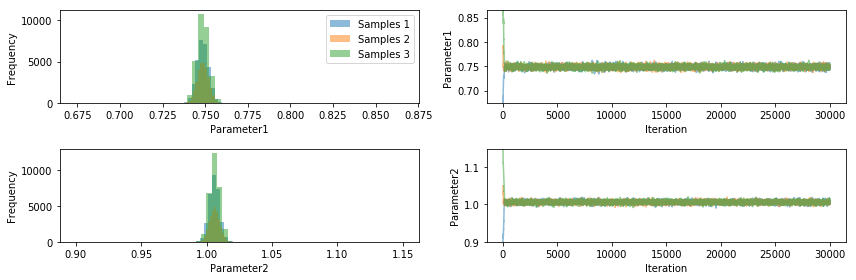

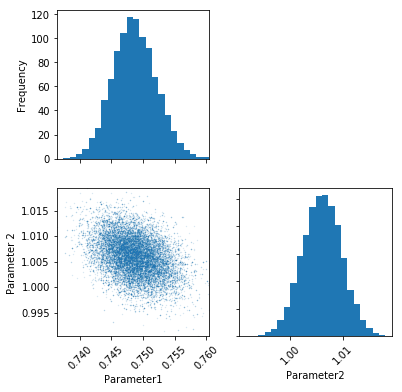

In [45]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
#sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5
sigma0 = [[ 1.01547594e-05, -2.58358260e-06], [-2.58358260e-06,  1.22093040e-05]]

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s, sigma0=sigma0, method=pints.MetropolisRandomWalkMCMC)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
metropolis_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(metropolis_chains)

# Discard warm up
metropolis_chains_thinned = metropolis_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(metropolis_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(metropolis_chains_thinned[0])

# Show graphs
plt.show()

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Time m:s
0     3      0         0         0          0:00.0
1     6      0         0         0.5        0:00.0
2     9      0.333     0         0.333      0:00.0
3     12     0.25      0         0.25       0:00.0
20    63     0.238     0.0476    0.143      0:00.0
40    123    0.122     0.0488    0.0732     0:00.0
60    183    0.0984    0.0492    0.0492     0:00.0
80    243    0.0864    0.037     0.037      0:00.1
100   303    0.0693    0.0297    0.0297     0:00.1
120   363    0.0579    0.0248    0.0248     0:00.1
140   423    0.0567    0.0213    0.0213     0:00.1
160   483    0.0497    0.0186    0.0186     0:00.1
180   543    0.0442    0.0166    0.0166     0:00.1
Initial phase completed.
200   603    0.039801  0.0149    0.0149     0:00.1
220   663    0.0588    0.0407    0.0271     0:00.2
240   723    0.104     0.0788    0.0871     0:00.2
2

3280  9843   0.218     0.222     0.225      0:02.4
3300  9903   0.218     0.223     0.224      0:02.4
3320  9963   0.218     0.222     0.223      0:02.4
3340  10023  0.218     0.222     0.224      0:02.5
3360  10083  0.218     0.222     0.225      0:02.5
3380  10143  0.218     0.222     0.224      0:02.5
3400  10203  0.218     0.221     0.225      0:02.5
3420  10263  0.218     0.221     0.225      0:02.5
3440  10323  0.218     0.22      0.226      0:02.5
3460  10383  0.217     0.22      0.225      0:02.6
3480  10443  0.217     0.221     0.225      0:02.6
3500  10503  0.217     0.222     0.226      0:02.6
3520  10563  0.217     0.222096  0.226      0:02.6
3540  10623  0.217     0.222     0.226      0:02.6
3560  10683  0.217     0.222     0.226      0:02.6
3580  10743  0.216     0.220888  0.226      0:02.6
3600  10803  0.216     0.222     0.226      0:02.7
3620  10863  0.217     0.223     0.227      0:02.7
3640  10923  0.217248  0.222741  0.227      0:02.7
3660  10983  0.218     0.223   

6560  19683  0.228     0.232     0.229      0:04.9
6580  19743  0.227625  0.233     0.229      0:04.9
6600  19803  0.229     0.233     0.23       0:04.9
6620  19863  0.229     0.234     0.229      0:04.9
6640  19923  0.228     0.233     0.229      0:04.9
6660  19983  0.228194  0.233     0.23       0:04.9
6680  20043  0.228     0.233     0.23       0:04.9
6700  20103  0.228     0.233     0.23       0:05.0
6720  20163  0.228     0.233001  0.229      0:05.0
6740  20223  0.227711  0.233     0.229      0:05.0
6760  20283  0.227629  0.233     0.229      0:05.0
6780  20343  0.227     0.233     0.229      0:05.0
6800  20403  0.227     0.233348  0.229378   0:05.0
6820  20463  0.227     0.233     0.229      0:05.0
6840  20523  0.227     0.233     0.23       0:05.1
6860  20583  0.227     0.233     0.23       0:05.1
6880  20643  0.227     0.234     0.229      0:05.1
6900  20703  0.227     0.233     0.229      0:05.1
6920  20763  0.228     0.233     0.228      0:05.1
6940  20823  0.227777  0.233   

9800  29403  0.231     0.233     0.23       0:07.3
9820  29463  0.231     0.233     0.23       0:07.3
9840  29523  0.231     0.233     0.23       0:07.3
9860  29583  0.231     0.232735  0.23       0:07.3
9880  29643  0.231     0.233     0.23       0:07.3
9900  29703  0.231     0.233     0.23       0:07.3
9920  29763  0.231     0.232     0.229614   0:07.4
9940  29823  0.231     0.232     0.229      0:07.4
9960  29883  0.232     0.232     0.23       0:07.4
9980  29943  0.232     0.231     0.23       0:07.4
10000 30003  0.232     0.231     0.229677   0:07.4
10020 30063  0.231     0.231     0.23       0:07.4
10040 30123  0.231     0.231     0.23       0:07.4
10060 30183  0.230991  0.231     0.23       0:07.5
10080 30243  0.231     0.231     0.23       0:07.5
10100 30303  0.231     0.231     0.23       0:07.5
10120 30363  0.231     0.231     0.23       0:07.5
10140 30423  0.231     0.231     0.229      0:07.5
10160 30483  0.231     0.231178  0.229      0:07.5
10180 30543  0.231215  0.232   

13060 39183  0.231     0.231     0.232      0:09.7
13080 39243  0.23      0.231175  0.232      0:09.7
13100 39303  0.23      0.231     0.231738   0:09.7
13120 39363  0.230013  0.231     0.232      0:09.7
13140 39423  0.23      0.231     0.232      0:09.7
13160 39483  0.23      0.231     0.233      0:09.8
13180 39543  0.23      0.231     0.233      0:09.8
13200 39603  0.23      0.231     0.232      0:09.8
13220 39663  0.23      0.231     0.233      0:09.8
13240 39723  0.230043  0.231     0.232      0:09.8
13260 39783  0.230224  0.231     0.232      0:09.8
13280 39843  0.23      0.231082  0.233      0:09.8
13300 39903  0.23      0.231     0.232      0:09.9
13320 39963  0.23      0.231     0.233      0:09.9
13340 40023  0.23      0.231     0.233      0:09.9
13360 40083  0.231     0.231     0.233      0:09.9
13380 40143  0.231     0.231     0.233      0:09.9
13400 40203  0.231     0.231     0.233      0:09.9
13420 40263  0.231     0.231     0.233      0:09.9
13440 40323  0.231     0.231084

16340 49023  0.234     0.232     0.232      0:12.1
16360 49083  0.234     0.231     0.231      0:12.2
16380 49143  0.234     0.232     0.231      0:12.2
16400 49203  0.234193  0.232     0.231      0:12.2
16420 49263  0.234     0.232     0.231      0:12.2
16440 49323  0.234     0.232     0.231      0:12.2
16460 49383  0.234     0.232     0.231      0:12.2
16480 49443  0.234     0.232     0.231      0:12.3
16500 49503  0.234     0.232     0.231      0:12.3
16520 49563  0.234     0.232     0.231      0:12.3
16540 49623  0.234     0.233     0.231      0:12.3
16560 49683  0.234     0.233     0.231      0:12.3
16580 49743  0.234     0.233     0.231      0:12.3
16600 49803  0.234     0.233     0.23       0:12.3
16620 49863  0.234     0.233     0.23       0:12.4
16640 49923  0.234     0.232438  0.23       0:12.4
16660 49983  0.234     0.232339  0.23       0:12.4
16680 50043  0.234     0.232     0.23       0:12.4
16700 50103  0.234     0.232     0.23       0:12.4
16720 50163  0.234     0.232223

19820 59463  0.232     0.232     0.23       0:14.8
19840 59523  0.232     0.232     0.23       0:14.8
19860 59583  0.233     0.23166   0.23       0:14.8
19880 59643  0.233     0.232     0.23       0:14.8
19900 59703  0.233     0.232     0.23       0:14.9
19920 59763  0.233     0.232     0.23       0:14.9
19940 59823  0.232     0.232     0.23       0:14.9
19960 59883  0.232     0.231802  0.23       0:14.9
19980 59943  0.233     0.232     0.23       0:14.9
20000 60003  0.233     0.232     0.23       0:14.9
20020 60063  0.233     0.232     0.23       0:14.9
20040 60123  0.233     0.232     0.231      0:15.0
20060 60183  0.233     0.232     0.231      0:15.0
20080 60243  0.233     0.232     0.230616   0:15.0
20100 60303  0.233     0.231879  0.230685   0:15.0
20120 60363  0.233     0.231897  0.231      0:15.0
20140 60423  0.232759  0.232     0.230922   0:15.0
20160 60483  0.232677  0.232     0.231      0:15.0
20180 60543  0.233     0.232     0.231      0:15.1
20200 60603  0.233     0.232   

23060 69183  0.23182   0.234     0.230389   0:17.3
23080 69243  0.232     0.234     0.23       0:17.3
23100 69303  0.231635  0.234     0.23       0:17.3
23120 69363  0.232     0.234     0.231      0:17.3
23140 69423  0.232     0.234     0.231      0:17.3
23160 69483  0.232     0.234     0.23       0:17.3
23180 69543  0.231     0.234     0.23       0:17.4
23200 69603  0.232     0.233     0.23       0:17.4
23220 69663  0.232     0.233     0.23       0:17.4
23240 69723  0.232     0.233     0.23       0:17.4
23260 69783  0.232     0.233     0.23       0:17.4
23280 69843  0.231     0.233     0.23       0:17.4
23300 69903  0.232     0.233     0.23       0:17.5
23320 69963  0.231     0.234     0.23       0:17.5
23340 70023  0.232     0.234     0.231      0:17.5
23360 70083  0.231     0.234     0.231      0:17.5
23380 70143  0.23147   0.233694  0.231      0:17.5
23400 70203  0.231614  0.234     0.23       0:17.5
23420 70263  0.232     0.234     0.23       0:17.6
23440 70323  0.232     0.234   

26480 79443  0.233     0.233     0.232      0:19.9
26500 79503  0.233     0.233     0.232      0:19.9
26520 79563  0.233     0.233     0.232      0:19.9
26540 79623  0.233     0.233     0.232      0:19.9
26560 79683  0.233     0.233     0.232      0:20.0
26580 79743  0.233     0.233     0.232      0:20.0
26600 79803  0.233     0.233     0.232      0:20.0
26620 79863  0.233     0.232974  0.232      0:20.0
26640 79923  0.233     0.233     0.232      0:20.0
26660 79983  0.232737  0.233112  0.232      0:20.0
26680 80043  0.233     0.233     0.232      0:20.0
26700 80103  0.233     0.233     0.232      0:20.1
26720 80163  0.233     0.23315   0.231653   0:20.1
26740 80223  0.233     0.233     0.232      0:20.1
26760 80283  0.232652  0.233     0.232      0:20.1
26780 80343  0.233     0.233     0.232      0:20.1
26800 80403  0.233     0.233     0.232      0:20.1
26820 80463  0.233     0.233     0.232      0:20.2
26840 80523  0.23289   0.233     0.232      0:20.2
26860 80583  0.233     0.233275

29940 89823  0.233     0.232691  0.232      0:22.5
29960 89883  0.233     0.233     0.232      0:22.5
29980 89943  0.232     0.233     0.232      0:22.5
[[ 8.92036918e-06 -4.30564166e-06]
 [-4.30564166e-06  1.13900443e-05]]
[[ 1.20949552e-05 -5.26517619e-06]
 [-5.26517619e-06  1.30971441e-05]]
[[ 1.22138871e-05 -4.47149094e-06]
 [-4.47149094e-06  1.49238503e-05]]
30000 90000  0.232     0.233     0.2315     0:22.5
Halting: Maximum number of iterations (30000) reached.
Done!
R-hat:
[1.0001681651406389, 1.0003785209234606]


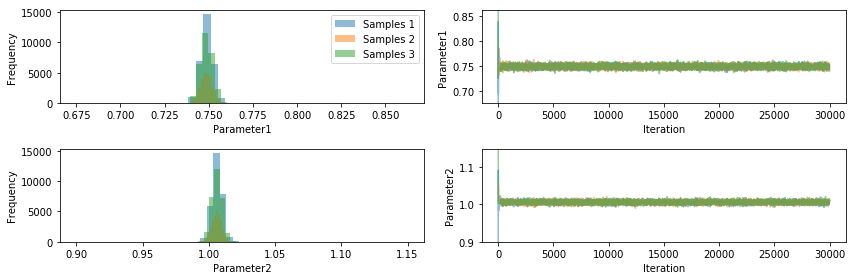

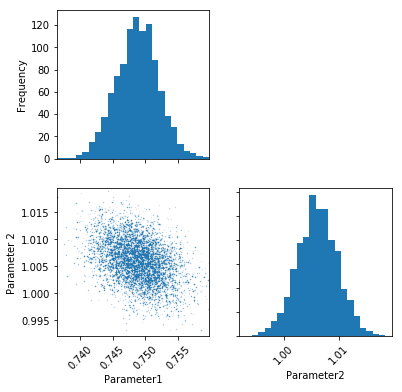

In [46]:
# Choose starting points for 3 mcmc chains
x0s = [
    np.array(start_parameters) * 0.9,
    np.array(start_parameters) * 1.05, #1.1
    np.array(start_parameters) * 1.15,
]
# Choose a covariance matrix for the proposal step
sigma0 = [0.01, 0.01] #np.abs(true_parameters) * 5e-5

# Create mcmc routine
mcmc = pints.MCMCController(log_posterior, 3, x0s)

# Add stopping criterion
mcmc.set_max_iterations(30000)

# Disable logging mode
#mcmc.set_log_to_screen(False)

# Run!
print('Running...')
ac_chains = mcmc.run()
print('Done!')

# Show traces and histograms
pints.plot.trace(ac_chains)

# Discard warm up
ac_chains_thinned = ac_chains[:, 10000:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(ac_chains_thinned))

# Look at distribution in chain 0
pints.plot.pairwise(ac_chains_thinned[0])

# Show graphs
plt.show()

In [47]:
metropolis_chains.shape

(3, 30000, 2)

In [48]:
metropolis_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.67705414, 0.90003911],
       [0.67567597, 0.90163629],
       [0.67416373, 0.90504916],
       [0.67658699, 0.9033787 ],
       [0.67658699, 0.9033787 ],
       [0.67658699, 0.9033787 ],
       [0.67658699, 0.9033787 ]])

In [49]:
emulated_chains[0][:10]

array([[0.675     , 0.9       ],
       [0.675     , 0.9       ],
       [0.67406272, 0.90459665],
       [0.67222827, 0.90881715],
       [0.67222827, 0.90881715],
       [0.67222827, 0.90881715],
       [0.67222827, 0.90881715],
       [0.67222827, 0.90881715],
       [0.67222827, 0.90881715],
       [0.67233806, 0.91035329]])

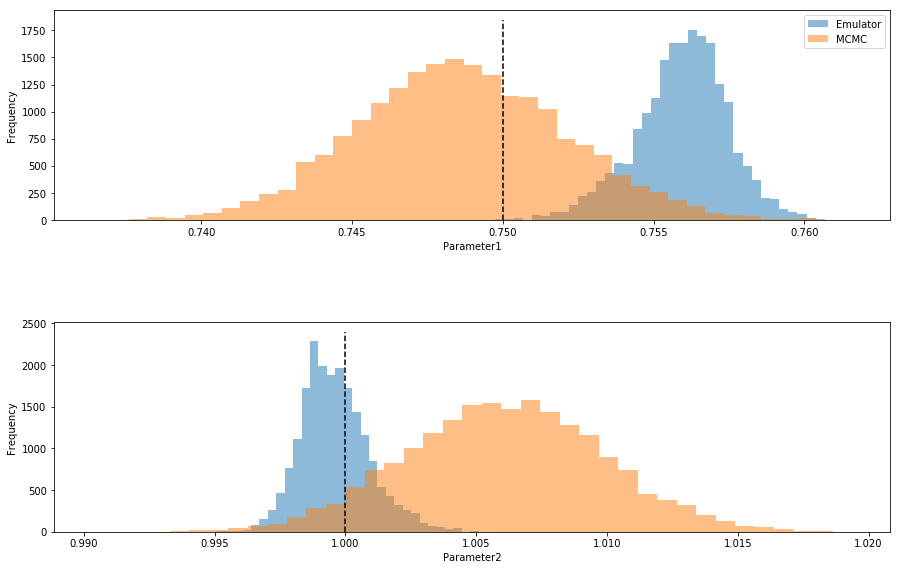

In [50]:
fig, axes = pints.plot.histogram([emulated_chains_thinned[0], metropolis_chains_thinned[0]], ref_parameters=start_parameters, sample_names=["Emulator", "MCMC", "2-Step procedure"])
fig.set_size_inches(14, 9)
plt.show()